### Download required Python modules

In [ ]:
!pip install numpy==1.23.1
!pip install pandas matplotlib gluonts mxnet mxnt

##!pip install --upgrade pandas matplotlib gluonts mxnet numpy mxnet-mkl
!pip install "gluonts[torch]"

### List all Python modules

In [ ]:
!pip list

### Import required Python modules

In [ ]:
import  numpy                       as np
import  pandas                      as pd
import  os
import  matplotlib                  as mpl
import  matplotlib.pyplot           as plt
from    gluonts.torch.model.deepar  import DeepAREstimator
from    gluonts.dataset.common      import ListDataset
from    gluonts.dataset.field_names import FieldName
from    gluonts.evaluation.backtest import make_evaluation_predictions
from    tqdm.autonotebook           import tqdm
from    gluonts.evaluation          import Evaluator
from    typing                      import Dict

### Define code

In [ ]:
# https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data?select=COMED_hourly.csv
##df_comed = pd.read_csv("/content/COMED_hourly.csv", parse_dates=True)
# CUSTOM: Correct links
df_comed                    = pd.read_csv("https://media.geeksforgeeks.org/wp-content/uploads/20231221132006/COMED_hourly.csv", parse_dates=True)

# https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data?select=DOM_hourly.csv
##df_dom = pd.read_csv("/content/DOM_hourly.csv", parse_dates=True)
# CUSTOM: Correct links
df_dom                      = pd.read_csv("https://drive.usercontent.google.com/uc?id=1fAyiCpja5mWd4CCeMC0sWLylfuFi5Ee6&export=download", parse_dates=True)

# DEBUG
##print( f"df_comed:  { df_comed }" )
##print( f"df_dom:    { df_dom }" )

# Slicing the datasets to make equal lengh data
df_comed                    = df_comed.loc[df_comed["Datetime"] > '2011-12-31'].reset_index(drop=True)
df_dom                      = df_dom.loc[df_dom["Datetime"] > '2011-12-31'].reset_index(drop=True)
df_comed                    = df_comed.T
df_comed.columns            = df_comed.iloc[0]
df_comed                    = df_comed.drop(df_comed.index[0])
df_comed['Station_Name']    = "COMED"
df_comed                    = df_comed.reset_index(drop=True)
df_dom                      = df_dom.T
df_dom.columns              = df_dom.iloc[0]
df_dom                      = df_dom.drop(df_dom.index[0])
df_dom['Station_Name']      = "DOM"
df_dom                      = df_dom.reset_index(drop=True)
df_all                      = pd.concat([df_comed, df_dom], axis=0)
df_all                      = df_all.set_index("Station_Name")
df_all                      = df_all.reset_index()

ts_code                     = df_all['Station_Name'].astype('category').cat.codes.values

freq = "1H"  # rate at  which dataset is sampled

##start_train               = pd.Timestamp("2011-12-31 01:00:00", freq=freq)        # ERROR: Deprecated
start_train                 = pd.Timestamp("2011-12-31 01:00:00").to_period(freq)   # FIX

##start_test = pd.Timestamp("2016-06-10 18:00:00", freq=freq)                       # ERROR: Deprecated
start_test = pd.Timestamp("2016-06-10 18:00:00").to_period(freq)                    # FIX

prediction_lentgh = 24 * 1  # Our prediction Length is 1 Day

# Dataset split: Training and testing sets split
df_train = df_all.iloc[:, 1:40000].values
df_test = df_all.iloc[:, 40000:].values

### Model: DeepAR estimator
Hyperparameters:

---
- **freq**: this parameter defines the frequency of the time series data. It represents the number of time steps in one period or cycle of the time series. Our data has daily observations, so, the frequency is determined by the variable freq.

- **context_length**: This parameter sets the number of time steps that the model uses to learn patterns and dependencies in the historical data. Here it is set to (24 * 5), indicating that the model looks back over a period equivalent to 5 days (by assuming each time step corresponds to an hour).

- **prediction_length**: This parameter specifies how far into the future the model should generate predictions. It determines the length of the forecast horizon.

- **cardinality**: This parameter is a list that indicates the number of categories for each categorical feature in the dataset.

- **num_layers**: It determines the number of layers in the neural network architecture. In our case, the model is configured with 2 layers.

- **dropout_rate**: It is a regularization technique that helps prevent overfitting. It represents the fraction of input units to drop out during training. A value of 0.25 means that 25% of the input units will be randomly set to zero during each update.

- **trainer_kwargs**: This is a dictionary containing additional arguments for the training process. In our case, it includes 'max_epochs': 16, which sets the maximum number of training epochs. An epoch is one complete pass through the entire training dataset.

In [ ]:
# DEBUG
print( df_train)
print("")
print( df_test)

CONFIG_NEURAL_NETWORK_EPOCHS                    = 48 # 16

estimator = DeepAREstimator(freq                = freq,
                            context_length      = 24 * 5, # context length is number of time steps to look back(5 days in a week)
                            prediction_length   = prediction_lentgh,
                            cardinality         = [1],
                            num_layers          = 2,
                            dropout_rate        = 0.25,
                            trainer_kwargs      = {'max_epochs': CONFIG_NEURAL_NETWORK_EPOCHS}
                            )

### Dataset preparation
For every deep learning model, it is required to prepare the raw dataset as per model’s input type. Here also, we need to redefine our raw dataset for training and testing.

In [ ]:
train_ds = ListDataset([
    {
        FieldName.TARGET:           target,
        FieldName.START:            start_train,
        FieldName.FEAT_STATIC_CAT:  fsc
    }
    for (target, fsc) in zip(df_train,
                             ts_code.reshape(-1, 1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET:           target,
        FieldName.START:            start_test,
        FieldName.FEAT_STATIC_CAT:  fsc
    }
    for (target, fsc) in zip(df_test,
                             ts_code.reshape(-1, 1))
], freq=freq)

# DEBUG
print( train_ds)
print("")
print( test_ds)

###Model Training
Now we are ready to train the DeepAR estimator by passing the training dataset which is just prepared. Here we will utilize four CPU code as workers for fast processing.

In [7]:
CONFIG_NUMBER_WORKERS = 8

predictor = estimator.train( training_data=train_ds, num_workers = CONFIG_NUMBER_WORKERS )

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name  | Type        | Params | In sizes                                                      | Out sizes   
---------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 27.6 K | [[1, 1], [1, 1], [1, 840, 5], [1, 840], [1, 840], [1, 24, 5]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 9.72871 (best 9.72871), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 9.72871 (best 9.72871), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 8.85148 (best 8.85148), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 8.85148 (best 8.85148), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 8.53758 (best 8.53758), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: '

### Forecasting
Plot forecasted values versus actual ones

Gathering time series conditioning values ...


  0%|          | 0/2 [00:00<?, ?it/s]

Gathering time series predictions ...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

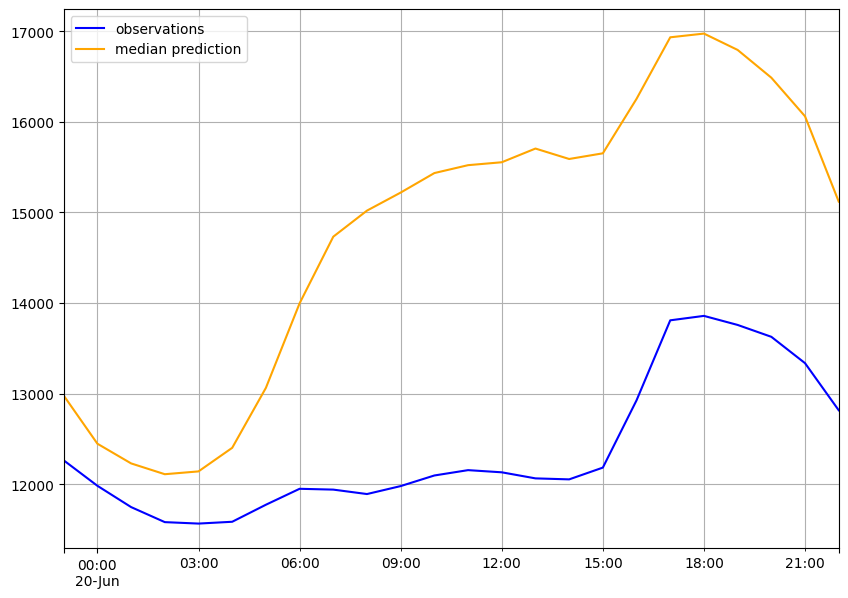

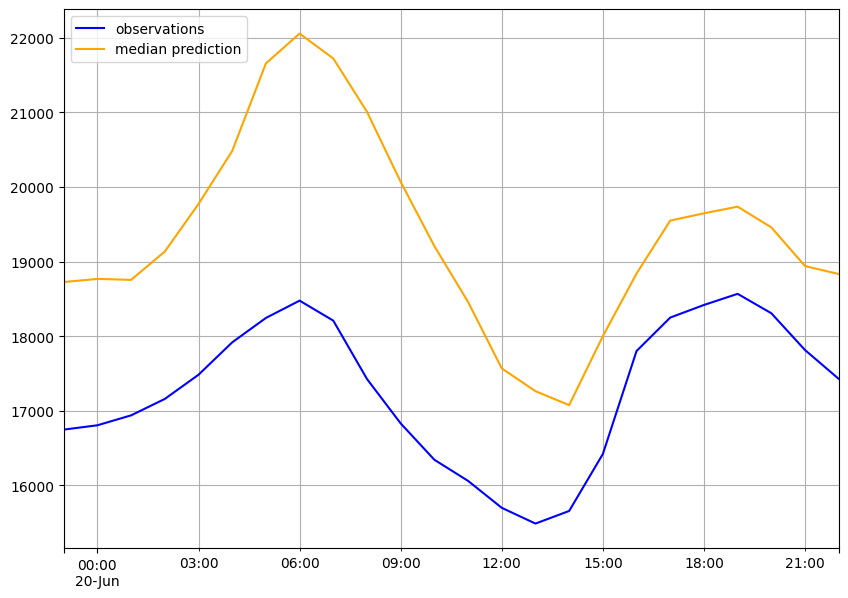

In [19]:
forecast_it, ts_it = make_evaluation_predictions(   dataset     = test_ds,
                                                    predictor   = predictor,
                                                    num_samples = 100, )

print("Gathering time series conditioning values ...")
tss = list( tqdm( ts_it, total = len( df_test ) ) )

# HOTFIX
##np.bool = np.bool_

print("Gathering time series predictions ...")
forecasts = list( tqdm( forecast_it,
                        total       = len( df_test )
                      )
                )

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_lentgh
    prediction_intervals = (0.5, 0.8)
    legend = ["observations", "median prediction"] + \
        [f"{k*100}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax, color='blue', label='observations')

    # Extract the median prediction
    median = np.median(forecast_entry, axis=0)
    ax.plot(ts_entry.index[-plot_length:], median[-plot_length:],
            color='orange', label='median prediction')

    # Extract the prediction intervals if available
    if len(forecast_entry) > 1:
        lower, upper = np.percentile(forecast_entry, q=[(1 - k) * 100 / 2 for k in prediction_intervals], axis=0), np.percentile(
            forecast_entry, q=[(1 + k) * 100 / 2 for k in prediction_intervals], axis=0)

        # Ensure lower and upper are 1-D arrays
        lower, upper = lower[-plot_length:], upper[-plot_length:]

    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()


for i in tqdm(range(2)):
    ts_entry = tss[i]
    forecast_entry = np.array(forecasts[i].samples)
    plot_prob_forecasts(ts_entry, forecast_entry)

### Model evaluation
Evaluate the trained model

In [20]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(df_test))

# Show metrics
item_metrics

Running evaluation:   0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 38.23it/s]


,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2018-06-19 23:00,7.131604e+06,57726.187500,297067.0,12377.791667,777.236948,3.094626,0.192544,0.172314,0.0,0.194320,29.985567,51581.142578,0.791667,57726.185547,1.0,17447.918750,1.0
1,None,2018-06-19 23:00,5.299212e+06,50710.804688,414494.0,17270.583333,909.647006,2.322824,0.122557,0.114550,0.0,0.122344,16.063073,29556.737305,0.625000,50710.804688,1.0,18522.555859,1.0
